In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from bs4 import BeautifulSoup
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import seaborn as sns
from tqdm import tqdm
import os

In [4]:
data=pd.read_csv('Reviews.csv')

In [5]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [7]:
data.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [8]:
data.dropna(inplace=True)

In [9]:
data.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [10]:
data.duplicated().any()

False

In [11]:
few=data[data.duplicated(subset=["UserId","ProfileName","Time","Text"],keep=False)]
few.shape

(232376, 10)

In [12]:
few[few['UserId']=='A395BORC6FGVXV']

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
136303,136304,B002Y7526Y,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
544172,544173,B000U9WZ54,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...


In [13]:
data1 = data.drop_duplicates(subset=['UserId','ProfileName','Time','Text'],keep='first',inplace=False)
data1.shape

(393914, 10)

In [14]:
data1[data1['HelpfulnessNumerator'] > data1['HelpfulnessDenominator']]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
44736,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
64421,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


In [15]:
#Removing them
data1 = data1[data1['HelpfulnessNumerator'] <= data1['HelpfulnessDenominator']]
data1.shape

(393912, 10)

In [16]:
data1.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

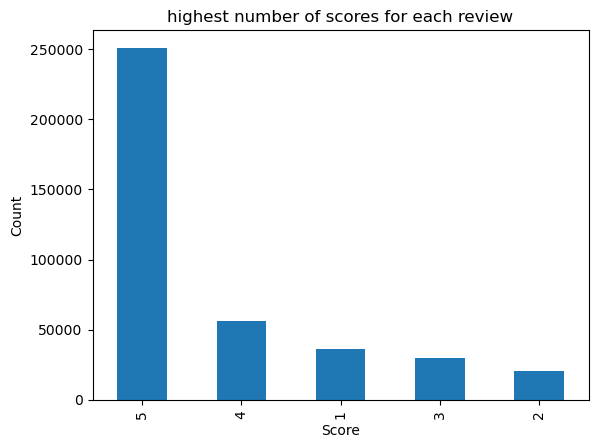

In [17]:
data1['Score'].value_counts().plot.bar()
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('highest number of scores for each review')
plt.show()

In [18]:
data2=data1.copy()

In [19]:
data2['Time'] = pd.to_datetime(data2['Time'],unit='s')
data2 = data2.sort_values('Time')
data2 = data2.reset_index(drop=True)
data2['Time']

0        1999-10-08
1        1999-10-25
2        1999-12-02
3        1999-12-06
4        2000-01-03
            ...    
393907   2012-10-26
393908   2012-10-26
393909   2012-10-26
393910   2012-10-26
393911   2012-10-26
Name: Time, Length: 393912, dtype: datetime64[ns]

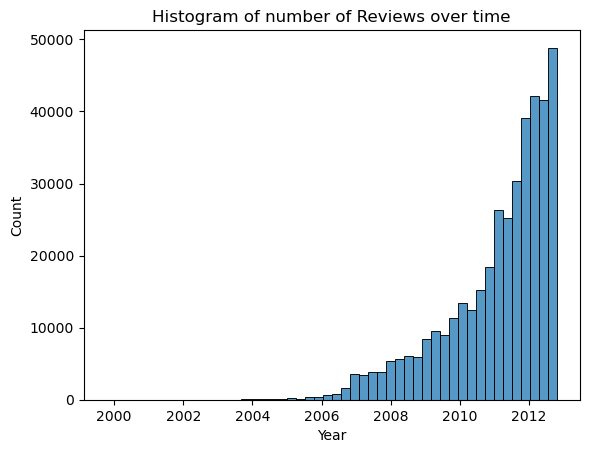

In [20]:
sns.histplot(data2['Time'],bins=50)
plt.ylabel('Count')
plt.xlabel('Year')
plt.title('Histogram of number of Reviews over time')
plt.show()

In [21]:
data1=data1[data1['Score']!=3]
data1.shape

(364145, 10)

In [22]:
def reviews(x):
    if x>3:
        return 1
    return 0

score_upd=data1['Score']
t=score_upd.map(reviews)
data1['Score']=t

In [23]:
data1.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


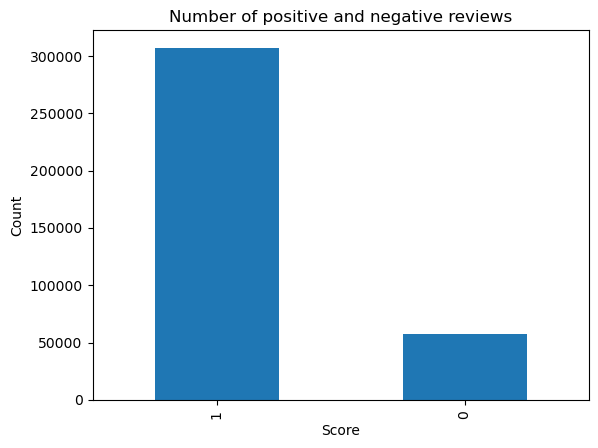

In [24]:
data1['Score'].value_counts().plot.bar()
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Number of positive and negative reviews')
plt.show()

In [25]:
data1['Score'].value_counts()

Score
1    307042
0     57103
Name: count, dtype: int64

In [26]:
data1['Score'].value_counts()

Score
1    307042
0     57103
Name: count, dtype: int64

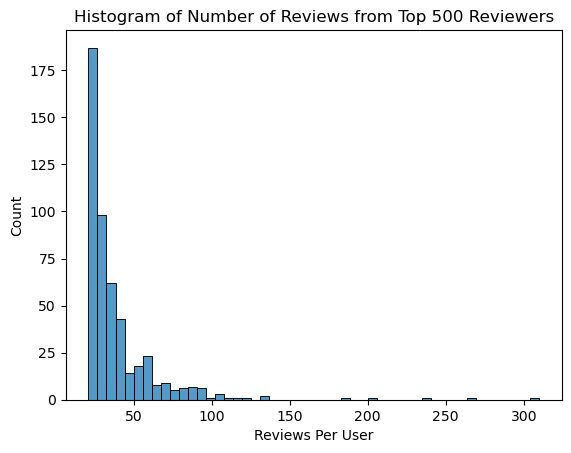

In [27]:
count = data1["UserId"].value_counts().nlargest(500)
sns.histplot(count, bins=50)
plt.ylabel('Count')
plt.xlabel('Reviews Per User')
plt.title('Histogram of Number of Reviews from Top 500 Reviewers')
plt.show()

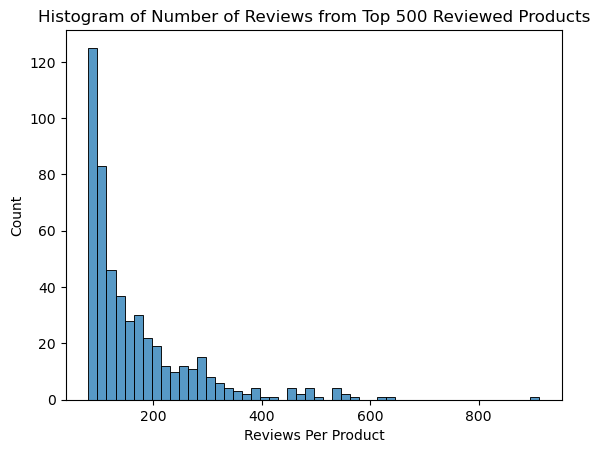

In [28]:
#Product popularity
top_500_product_count = data2["ProductId"].value_counts().nlargest(500)
sns.histplot(top_500_product_count, bins=50)
plt.ylabel('Count')
plt.xlabel('Reviews Per Product')
plt.title('Histogram of Number of Reviews from Top 500 Reviewed Products')
plt.show()

# Preprocessing Text data

Hence in the Preprocessing phase we do the following in the order below:-

1.Begin by removing the html tags

2.Remove any punctuations or limited set of special characters like , or . or # etc.

3.Check if the word is made up of english letters and is not alpha-numeric

4.Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)

5.Convert the word to lowercase

6.Remove Stopwords

In [29]:
data3=data1.copy()
data3.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [30]:
data3=data3.sample(100000, random_state=100)
data3.shape

(100000, 10)

In [31]:
from tqdm import tqdm
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])



preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(data3['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    # removing html tags
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    # removing extra spaces and numbers
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    # removing non alphabels
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords and len(e) > 2)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:31<00:00, 3139.40it/s]


In [32]:
data3.shape

(100000, 10)

In [33]:
#combining required columns
data3['clean_text'] = preprocessed_reviews
data3 = data3[['Time','Text','clean_text','Score']]
#reseting index
data3 = data3.reset_index(drop=True)

In [34]:
data3

,Time,Text,clean_text,Score
0,1206835200,I love this tea. Wylers is the best peach tea...,love tea wylers best peach tea instant tea not...,1
1,1339632000,Very good price and excellent coffee.. Packed ...,good price excellent coffee packed perfect les...,1
2,1250726400,I can't believe I actually paid money for this...,not believe actually paid money stuff gritty t...,0
3,1333324800,So glad I met coconut oil! Great medicinal be...,glad met coconut oil great medicinal benefits ...,1
4,1342137600,Roland has always been a product line i could ...,roland always product line could trust full in...,1
...,...,...,...,...
99995,1236729600,An excellent product that is in a convenient s...,excellent product convenient size provider shi...,1
99996,1239667200,Tiny bottles perfect for night feeding! A litt...,tiny bottles perfect night feeding little pric...,1
99997,1170720000,We enjoy a cup of coffee with Bailey's Irish C...,enjoy cup coffee bailey irish cream decided tr...,0
99998,1280102400,Happy to find this product. Could not locate ...,happy find product could not locate grocery st...,1


In [35]:
#Stemming
import pandas as pd
from nltk.stem import PorterStemmer

# Assuming your DataFrame is named df and has a 'Text' column
# You can replace 'df' and 'Text' with your actual DataFrame and column names

# Initialize the Porter Stemmer
porter_stemmer = PorterStemmer()

# Apply stemming to the 'Text' column and create a new column 'Stemmed'
data3['Stemmed'] = data3['clean_text'].apply(lambda x: ' '.join(porter_stemmer.stem(word) for word in x.split()))

# Display the DataFrame with the new 'Stemmed' column
data3.head()

,Time,Text,clean_text,Score,Stemmed
0,1206835200,I love this tea. Wylers is the best peach tea...,love tea wylers best peach tea instant tea not...,1,love tea wyler best peach tea instant tea not ...
1,1339632000,Very good price and excellent coffee.. Packed ...,good price excellent coffee packed perfect les...,1,good price excel coffe pack perfect less cent ...
2,1250726400,I can't believe I actually paid money for this...,not believe actually paid money stuff gritty t...,0,not believ actual paid money stuff gritti tast...
3,1333324800,So glad I met coconut oil! Great medicinal be...,glad met coconut oil great medicinal benefits ...,1,glad met coconut oil great medicin benefit use...
4,1342137600,Roland has always been a product line i could ...,roland always product line could trust full in...,1,roland alway product line could trust full int...


In [36]:
#sortimg based on time
data3['Time'] = pd.to_datetime(data3['Time'],unit='s')
data3 = data3.sort_values('Time')
data3 = data3.reset_index(drop=True)
data3.head()

,Time,Text,clean_text,Score,Stemmed
0,2000-01-09,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movie movie collection filled comedy actio...,1,one movi movi collect fill comedi action whate...
1,2000-01-19,"I, myself always enjoyed this movie, it's very...",always enjoyed movie funny entertaining not he...,0,alway enjoy movi funni entertain not hesit pic...
2,2000-01-24,I bought a few of these after my apartment was...,bought apartment infested fruit flies hours tr...,1,bought apart infest fruit fli hour trap attrac...
3,2000-02-26,What happens when you say his name three times...,happens say name three times michael keaten st...,1,happen say name three time michael keaten star...
4,2000-06-23,This was a really good idea and the final prod...,really good idea final product outstanding use...,1,realli good idea final product outstand use de...


# Vectorization(bag of words)

In [37]:
#bag of wordsfrom sklearn.feature_extraction.text import CountVectorizer

# count_vect = CountVectorizer(ngram_range=(1,2) ) 
count_vect = CountVectorizer() 
final_bow_count = count_vect.fit_transform(data3['Stemmed'].values)

In [38]:
print(final_bow_count)

  (0, 26392)	1
  (0, 24476)	2
  (0, 7726)	1
  (0, 13542)	1
  (0, 7800)	1
  (0, 311)	1
  (0, 41558)	1
  (0, 11904)	1
  (0, 41157)	1
  (0, 5496)	1
  (1, 24476)	2
  (1, 41157)	1
  (1, 1106)	1
  (1, 12135)	1
  (1, 14847)	1
  (1, 12193)	1
  (1, 25612)	1
  (1, 17378)	1
  (1, 28319)	1
  (1, 7271)	2
  (1, 11697)	3
  (1, 16462)	1
  (1, 22823)	1
  (1, 28568)	1
  (1, 22506)	1
  :	:
  (99998, 26158)	1
  (99998, 26275)	1
  (99998, 11229)	1
  (99999, 35976)	1
  (99999, 21920)	1
  (99999, 42170)	1
  (99999, 22068)	4
  (99999, 16162)	1
  (99999, 12431)	1
  (99999, 41991)	1
  (99999, 22334)	1
  (99999, 13155)	1
  (99999, 37178)	1
  (99999, 24538)	1
  (99999, 31630)	1
  (99999, 3613)	1
  (99999, 35475)	1
  (99999, 7591)	1
  (99999, 3887)	1
  (99999, 31804)	1
  (99999, 8856)	1
  (99999, 3873)	1
  (99999, 21170)	1
  (99999, 2525)	1
  (99999, 10219)	1


In [39]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler

final_bow_nppp = MaxAbsScaler().fit_transform(final_bow_count )

In [40]:
print(final_bow_nppp)

  (0, 311)	0.5
  (0, 5496)	0.14285714285714285
  (0, 7726)	0.25
  (0, 7800)	0.25
  (0, 11904)	0.25
  (0, 13542)	0.1111111111111111
  (0, 24476)	0.4
  (0, 26392)	0.041666666666666664
  (0, 41157)	0.16666666666666666
  (0, 41558)	0.2
  (1, 1106)	0.2
  (1, 2602)	0.25
  (1, 7271)	1.0
  (1, 11697)	1.0
  (1, 11854)	0.5
  (1, 11875)	0.3333333333333333
  (1, 12135)	0.14285714285714285
  (1, 12193)	0.3333333333333333
  (1, 13091)	0.2
  (1, 14847)	0.5
  (1, 16462)	0.3333333333333333
  (1, 17378)	0.3333333333333333
  (1, 22506)	0.1
  (1, 22823)	0.2
  (1, 24476)	0.4
  :	:
  (99998, 38084)	0.2
  (99998, 38256)	0.1111111111111111
  (99998, 38916)	0.09090909090909091
  (99999, 2525)	0.3333333333333333
  (99999, 3613)	0.1
  (99999, 3873)	0.14285714285714285
  (99999, 3887)	0.14285714285714285
  (99999, 7591)	0.03225806451612903
  (99999, 8856)	0.2
  (99999, 10219)	1.0
  (99999, 12431)	0.08333333333333333
  (99999, 13155)	0.125
  (99999, 16162)	0.14285714285714285
  (99999, 21170)	0.1
  (99999, 21920)	

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [42]:
#Train-Test-split (standrad scaler)

x=final_bow_nppp
y=data3['Score']
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=100)

print('x_train',X_train.shape)
print('x_test',X_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

x_train (70000, 43028)
x_test (30000, 43028)
y_train (70000,)
y_test (30000,)


# RF

In [45]:
#Train-Test-split (standrad scaler)

x=final_bow_count
y=data3['Score']
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=100)

print('x_train',X_train.shape)
print('x_test',X_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

x_train (70000, 43056)
x_test (30000, 43056)
y_train (70000,)
y_test (30000,)


In [46]:
rf_model=RandomForestClassifier()

In [47]:
rf_model.fit(X_train,y_train)

RandomForestClassifier()

In [48]:
rf_pred=rf_model.predict(X_test)

In [49]:
#eveluatemodels
rf_accuracy=accuracy_score(y_test,rf_pred)
print('Random Forest accuracy', rf_accuracy)

Random Forest accuracy 0.8751666666666666


In [ ]:

If you want to visualize the average precision, recall, F1-score, and support for the two classes based on the new classification report you provided, you can use the following Python code:

python
Copy code
import matplotlib.pyplot as plt
import numpy as np

# Values from your classification report
accuracy=[0.88,0.8797]
precision = [0.95, 0.88]
recall = [0.23, 1.00]
f1_score = [0.37, 0.93]


# Calculate averages
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
avg_f1_score = np.mean(f1_score)
avg_support = np.mean(support)

averages = [avg_precision, avg_recall, avg_f1_score, avg_support]

metrics = ['Precision', 'Recall', 'F1-Score', 'Support']

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.4
index = np.arange(len(metrics))

bars = ax.bar(index, averages, bar_width, color='blue', alpha=0.7)

ax.set_xlabel('Metrics')
ax.set_ylabel('Average Value')
ax.set_title('Average Precision, Recall, F1-Score, and Support')
ax.set_xticks(index)
ax.set_xticklabels(metrics)

# Display the values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()